# ALS signature using S-PrediXcan

In [37]:
from datetime import date
today = date.today()
date= today.strftime("%B %d, %Y")
import getpass
import os
cwd = os.getcwd()

In [36]:
print("Date: ", date)
print("Analysed by: ", getpass.getuser())
print("Current working directory: {0}".format(cwd))

Date:  August 11, 2022
Analysed by:  saezs
Current working directory: /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning



# Workflow

    (1) Use SignatureSearch for getting drugs against ALS impute signatures
        - Project Mine: 
   
# Files I need

    (1) List of up-/downregulated genes in ALS

    - /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv
    
    (2) List of approved drugs by DRUGBANK ("In DrugBank the status of approved is given to the drugs that have been officially accepted for commercialization in at least one jurisdiction at a given time. Due to the presence of different regulatory agencies around the world, once a drug is approved, this status will remain in the drug card even if the drug is later withdrawn from the market  in a particular jurisdiction or under investigation for a different indication. It is very common to see drugs with different statuses and thus, to confirm the status in a determinate jurisdiction, it is recommended to consult the "Product" section in the drug card") https://dev.drugbank.com/guides/terms/approved-drug
    
    - /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/DB.drug_groups.tab
    - /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/information.db.rda
    


    
# Additional information:
Signature Search package information can be found __[here](https://bioconductor.org/packages/release/bioc/vignettes/signatureSearch/inst/doc/signatureSearch.html#References)__





# SignatureSearch with Spinal cord ALS signatures

In [12]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library('org.Hs.eg.db')
columns(org.Hs.eg.db)

data = fread("VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header=T)
head(data)
raw.pvalue = data$pvalue
Padj.FDR = p.adjust(raw.pvalue, method = "fdr")
table(Padj.FDR)
print = cbind(data, Padj.FDR)
write.csv(print, "VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv")
print <- filter(print, Padj.FDR < 0.05)
UP = filter(print, zscore > 0)
print(UP)
DN = filter(print, zscore < 0)
print(DN)

data <- print 
data = data %>% separate(gene, c("ENS"), extra = "drop", fill = "right")
head(data)
symbols <- as.character(data$ENS)
head(symbols)
con <- mapIds(org.Hs.eg.db, symbols, 'ENTREZID', 'ENSEMBL')
con <- as.data.frame(con)
head(con)
write.table(con, "sp.conversion.txt", row.names =T, col.names = F, sep=" ", quote = F)
data2 <- read.table("sp.conversion.txt", header = F)
head(data2)
colnames <- c("ENS", "geneID")
names(data2)<- colnames
head(data2)
merged = merge(data, data2, by = "ENS", all = F)
head(merged)
dim(merged)

head(merged)


data3 <- filter(merged, Padj.FDR < 0.05)
dim(data3)

# Select Up/Down signatures (select ALL significant DEGs after bonferroni correction)
topUP <- filter(data3, zscore > 0)
dim(topUP)
upset = as.character(topUP$geneID)


topDN <- filter(data3, zscore < 0)
dim(topDN)
downset = as.character(topDN$geneID)

# Load drug perturbation libraries

library(mygene)
library(Hmisc)
library(signatureSearch)
library(ExperimentHub); library(rhdf5)
eh <- ExperimentHub()
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
lincs <- eh[["EH3226"]]; lincs_expr <- eh[["EH3227"]]
h5ls(lincs)

#CMAP method
qsig_cmap <- qSig(query = list(upset=upset, downset=downset), 
                  gess_method="CMAP", refdb=lincs)
                  
cmap <- gess_cmap(qSig=qsig_cmap, chunk_size=5000, workers=1)
cmap
df_cmap  = as.data.frame(cmap@result)
write.csv(df_cmap, "VR.ALS.cmapmethod.lincsDS.SpinalCordc1FDR.csv")


#LINCS method using the same pertub. database and UP/DN regulated genes
qsig_lincs <- qSig(query = list(upset=upset, downset=downset), 
                   gess_method="LINCS", refdb=lincs)
lincsm <- gess_lincs(qsig_lincs, sortby="NCS", tau=TRUE, workers=1)
result(lincsm)
df_lincs  = as.data.frame(lincsm@result)
write.csv(df_lincs, "VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv")

# cmap dataset

eh <- ExperimentHub()
cmap <- eh[["EH3223"]]; cmap_expr <- eh[["EH3224"]]
h5ls(cmap)


qsig_cmap <- qSig(query = list(upset=upset, downset=downset), 
                  gess_method="CMAP", refdb=cmap)
                  
cmap <- gess_cmap(qSig=qsig_cmap, chunk_size=5000, workers=1)
cmap
df_cmap  = as.data.frame(cmap@result)
write.csv(df_cmap, "VR.ALS.cmapmethod.cmapDS.SpinalCordc1FDR.csv")





R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> library(data.table)
> library(tidyverse)
> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library('org.Hs.eg.db')
> columns(org.Hs.eg.db)
 [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDEN

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1086 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn1086 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpo

# Plot results from SignatureSearch 

In [49]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/

module load R/4.1.0
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)


  
lincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
head(lincs)
groups <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/DB.drug_groups.tab")
head(groups)
colnames(groups) <- c("group", "primary_key")


load(file = "/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/information.db.rda")
head(info)
info$pert <- tolower(info$name)

merged <- merge(groups, info, by = "primary_key")

merged2 <- merge(merged, lincs, by = "pert")

merged2 <- filter(merged2, group == "approved")



df_means <- merged2 %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
data <- as.data.frame(df_means)
write.table(data, "/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.df.means.tab", quote = F,sep = "\t", row.names = F)

highlight_df <- data %>% 
             filter(pert == "zafirlukast")
ggplot(data, aes(x = reorder(pert, NCS), y = NCS)) + 
geom_point(size = 1, color = "gray") + theme_light(15)+ ggtitle("All Approved Drugs") + ylim(-1.5,1.5) +

xlab("Approved drug") +
    ylab("Mean normalized score") + scale_x_discrete(expand=c(0.1, 0)) +
    geom_point(data=highlight_df, 
             aes(x=pert,y=NCS), 
             color='red', size = 1)
    
ggsave("All.Drugs.svg",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
highlight_df <- data %>% 
             filter(pert == "edaravone")

 ggplot(data, aes(reorder(pert, NCS), y = NCS)) + 
  geom_point(size = 0.5) +
  geom_point(data=highlight_df, 
             aes(x=pert,y=NCS), 
             color='red', size = 0.5) +
            xlab("Approved drug") +
    ylab("Mean normalized score")
    
    
ggsave("All.Drugs2.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
hhhhhhhiugi
head(data)
top20 <- data[order(data$NCS),] 
head(top20)

unique <- distinct(top20, pert, .keep_all = TRUE)
head(unique)
top20unique <- unique %>% slice(1:20)
top20unique <- select(top20unique, pert)
merged2 <- merge(top20unique, lincs, by = "pert")
print(merged2)

data <- merged2

p <- ggplot(data, aes(pert, NCS))
p + geom_point(aes(colour = cell))

cbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",
"#332288", "#AA4499", "#999933","#44AA99", 
"#6699CC", "#C476A9","#E9C766","#74C476",
"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",
"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",
"#FFF7FB", "#74C476","#CB181D" )


p + scale_color_manual(values = cbp1)

df_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))
head(df_means)
head(data)

ggplot(data = data) +
  aes((x=reorder(pert,-NCS)), y = NCS) +
  geom_point(aes(colour = cell),  size = 2) + 
  geom_point(data=df_means, 
             col="black",  
             size = 4,
             shape = 23,
             fill = "skyblue4") + scale_color_manual(values = cbp1) + coord_flip() +
  labs(x = "Drug",
    y = "Normalized Connectivity Score",
    colour = "Cell line"
  ) +
  theme_light(15)+ ggtitle("LINCS method/ LINCS database") + ylim(-2,2)
  
ggsave("DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  dpi = 300)
  
 library(mygene)
library(Hmisc)
library(signatureSearch)

drugs <- data$pert
dup_hyperG_res <- tsea_dup_hyperG(drugs = drugs, universe = "Default", 
                                  type = "GO", ont="MF", pvalueCutoff=0.05, 
                                  pAdjustMethod="BH", qvalueCutoff = 0.05, 
                                  minGSSize = 10, maxGSSize = 500)
                                  
                                  
dup_hyperG_res <- as.data.frame(result(dup_hyperG_res))
write.table(dup_hyperG_res, "dup_hyperG_res.VR.DrugBankApproved.tab", sep = "\t", quote = F, row.names = F)


dup_hyperG_k_res <- tsea_dup_hyperG(drugs=drugs, universe="Default", type="KEGG",
                                    pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.05,
                                    minGSSize=10, maxGSSize=500)
result(dup_hyperG_k_res)
#dup_hyperG_k_res <- as.data.frame(result(dup_hyperG_k_res))
#write.table(dup_hyperG_k_res, "dup_hyperG_k_res.VR.DrugBankApproved.tab", sep = "\t", quote = F, row.names = F)

dup_rct_res <- tsea_dup_hyperG(drugs=drugs, type="Reactome",
                               pvalueCutoff=0.05, qvalueCutoff=0.05, readable=TRUE)
result(dup_rct_res)
dup_rct_res <- as.data.frame(result(dup_rct_res))
write.table(dup_rct_res, "dup_rct_res.VR.DrugBankApproved.tab", sep = "\t", quote = F, row.names = F)




postscript(file="saving_plot4.ps")
p1 = dtnetplot(drugs = drugs(dup_hyperG_k_res), set = "hsa04080", 
          desc="Neuroactive ligand-receptor interaction")
dev.off()

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1062 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn1062 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> 
> 
>   
> lincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)
> head(lincs)
   V1          pert     PCID    cell   type trend       WTCS    WTCS_Pval
1:  1 BRD-K69795440 44246520    VCAP trt_cp  down -0.7096592 1.262036e-05
2:  2    sildenafil     5212     ASC trt_cp    up  0.6980398 1.314258e-05
3:  3     PD-160170  9820766     ASC trt_cp  down -0.6471565 1.536202e-05
4:  4 BRD-A82323890 15115512 FIBRNPC trt_cp    up  0.6807512 1.388239e-05
5:  5 BRD-K45156967 44620852     PC3 trt_cp    up  0.6733886 1.423054e-05
6:  6          DMBI  5353593    HA1E trt_cp    up  0.6694761 1.440461e-05
       WTCS_FDR       NCS       Tau TauRefSize     NCSct N_upset N_downset
1: 9.084427e-05 -1.814553 -99.96735       6126 0.9576124       9        13
2: 9.084427e-05  1.796871  99.87207       2345 0.0000000       9        13
3: 9.084427e-05 -1.790330 -99.95736       2345 0.8182774       9        13
4: 9.084427e-05  1

Saving 7 x 7 in image


>   
> highlight_df <- data %>% 
+              filter(pert == "edaravone")
> 
>  ggplot(data, aes(reorder(pert, NCS), y = NCS)) + 
+   geom_point(size = 0.5) +
+   geom_point(data=highlight_df, 
+              aes(x=pert,y=NCS), 
+              color='red', size = 0.5) +
+             xlab("Approved drug") +
+     ylab("Mean normalized score")
>     
>     
> ggsave("All.Drugs2.png",
+   plot = last_plot(),
+   device = NULL,
+   path = NULL,
+   scale = 1,
+   dpi = 300)


Saving 7 x 7 in image


> hhhhhhhiugi


Error: object 'hhhhhhhiugi' not found
Execution halted
bash: line 5: syntax error near unexpected token `)'
bash: line 5: `ize=10, maxGSSize=500)'


CalledProcessError: Command 'b'cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/\n\nmodule load R/4.1.0\nR --vanilla --no-save\nlibrary(data.table)\nlibrary(tidyverse)\nlibrary(ggplot2)\nlibrary(dplyr)\nlibrary(RColorBrewer)\n\n\n  \nlincs <- fread("VR.ALS.lincsmethod.lincsDS.SpinalCordc1FDR.csv", header = T)\nhead(lincs)\ngroups <- fread("/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/DB.drug_groups.tab")\nhead(groups)\ncolnames(groups) <- c("group", "primary_key")\n\n\nload(file = "/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/information.db.rda")\nhead(info)\ninfo$pert <- tolower(info$name)\n\nmerged <- merge(groups, info, by = "primary_key")\n\nmerged2 <- merge(merged, lincs, by = "pert")\n\nmerged2 <- filter(merged2, group == "approved")\n\n\n\ndf_means <- merged2 %>% group_by(pert) %>% summarise(NCS=mean(NCS))\nhead(df_means)\ndata <- as.data.frame(df_means)\nwrite.table(data, "DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.df.means.tab", quote = F,sep = "\\t", row.names = F)\n\nhighlight_df <- data %>% \n             filter(pert == "zafirlukast")\nggplot(data, aes(x = reorder(pert, NCS), y = NCS)) + \ngeom_point(size = 1, color = "gray") + theme_light(15)+ ggtitle("All Approved Drugs") + ylim(-1.5,1.5) +\n\nxlab("Approved drug") +\n    ylab("Mean normalized score") + scale_x_discrete(expand=c(0.1, 0)) +\n    geom_point(data=highlight_df, \n             aes(x=pert,y=NCS), \n             color=\'red\', size = 1)\n    \nggsave("All.Drugs.svg",\n  plot = last_plot(),\n  device = NULL,\n  path = NULL,\n  scale = 1,\n  dpi = 300)\n  \nhighlight_df <- data %>% \n             filter(pert == "edaravone")\n\n ggplot(data, aes(reorder(pert, NCS), y = NCS)) + \n  geom_point(size = 0.5) +\n  geom_point(data=highlight_df, \n             aes(x=pert,y=NCS), \n             color=\'red\', size = 0.5) +\n            xlab("Approved drug") +\n    ylab("Mean normalized score")\n    \n    \nggsave("All.Drugs2.png",\n  plot = last_plot(),\n  device = NULL,\n  path = NULL,\n  scale = 1,\n  dpi = 300)\nhhhhhhhiugi\nhead(data)\ntop20 <- data[order(data$NCS),] \nhead(top20)\n\nunique <- distinct(top20, pert, .keep_all = TRUE)\nhead(unique)\ntop20unique <- unique %>% slice(1:20)\ntop20unique <- select(top20unique, pert)\nmerged2 <- merge(top20unique, lincs, by = "pert")\nprint(merged2)\n\ndata <- merged2\n\np <- ggplot(data, aes(pert, NCS))\np + geom_point(aes(colour = cell))\n\ncbp1  <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733",\n"#332288", "#AA4499", "#999933","#44AA99", \n"#6699CC", "#C476A9","#E9C766","#74C476",\n"#27698D","#AF87B9","#D9D6AB" ,"#B3D69C",\n"#60ABD4", "#E573E5","#74C476","#888888", "#C476A9", "#AE017E", "#E5F5F9",\n"#FFF7FB", "#74C476","#CB181D" )\n\n\np + scale_color_manual(values = cbp1)\n\ndf_means <- data %>% group_by(pert) %>% summarise(NCS=mean(NCS))\nhead(df_means)\nhead(data)\n\nggplot(data = data) +\n  aes((x=reorder(pert,-NCS)), y = NCS) +\n  geom_point(aes(colour = cell),  size = 2) + \n  geom_point(data=df_means, \n             col="black",  \n             size = 4,\n             shape = 23,\n             fill = "skyblue4") + scale_color_manual(values = cbp1) + coord_flip() +\n  labs(x = "Drug",\n    y = "Normalized Connectivity Score",\n    colour = "Cell line"\n  ) +\n  theme_light(15)+ ggtitle("LINCS method/ LINCS database") + ylim(-2,2)\n  \nggsave("DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png",\n  plot = last_plot(),\n  device = NULL,\n  path = NULL,\n  scale = 1,\n  dpi = 300)\n  \n library(mygene)\nlibrary(Hmisc)\nlibrary(signatureSearch)\n\ndrugs <- data$pert\ndup_hyperG_res <- tsea_dup_hyperG(drugs = drugs, universe = "Default", \n                                  type = "GO", ont="MF", pvalueCutoff=0.05, \n                                  pAdjustMethod="BH", qvalueCutoff = 0.05, \n                                  minGSSize = 10, maxGSSize = 500)\n                                  \n                                  \ndup_hyperG_res <- as.data.frame(result(dup_hyperG_res))\nwrite.table(dup_hyperG_res, "dup_hyperG_res.VR.DrugBankApproved.tab", sep = "\\t", quote = F, row.names = F)\n\n\ndup_hyperG_k_res <- tsea_dup_hyperG(drugs=drugs, universe="Default", type="KEGG",\n                                    pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.05,\n                                    minGSSize=10, maxGSSize=500)\nresult(dup_hyperG_k_res)\n#dup_hyperG_k_res <- as.data.frame(result(dup_hyperG_k_res))\n#write.table(dup_hyperG_k_res, "dup_hyperG_k_res.VR.DrugBankApproved.tab", sep = "\\t", quote = F, row.names = F)\n\ndup_rct_res <- tsea_dup_hyperG(drugs=drugs, type="Reactome",\n                               pvalueCutoff=0.05, qvalueCutoff=0.05, readable=TRUE)\nresult(dup_rct_res)\ndup_rct_res <- as.data.frame(result(dup_rct_res))\nwrite.table(dup_rct_res, "dup_rct_res.VR.DrugBankApproved.tab", sep = "\\t", quote = F, row.names = F)\n\n\n\n\npostscript(file="saving_plot4.ps")\np1 = dtnetplot(drugs = drugs(dup_hyperG_k_res), set = "hsa04080", \n          desc="Neuroactive ligand-receptor interaction")\ndev.off()\n'' returned non-zero exit status 2.

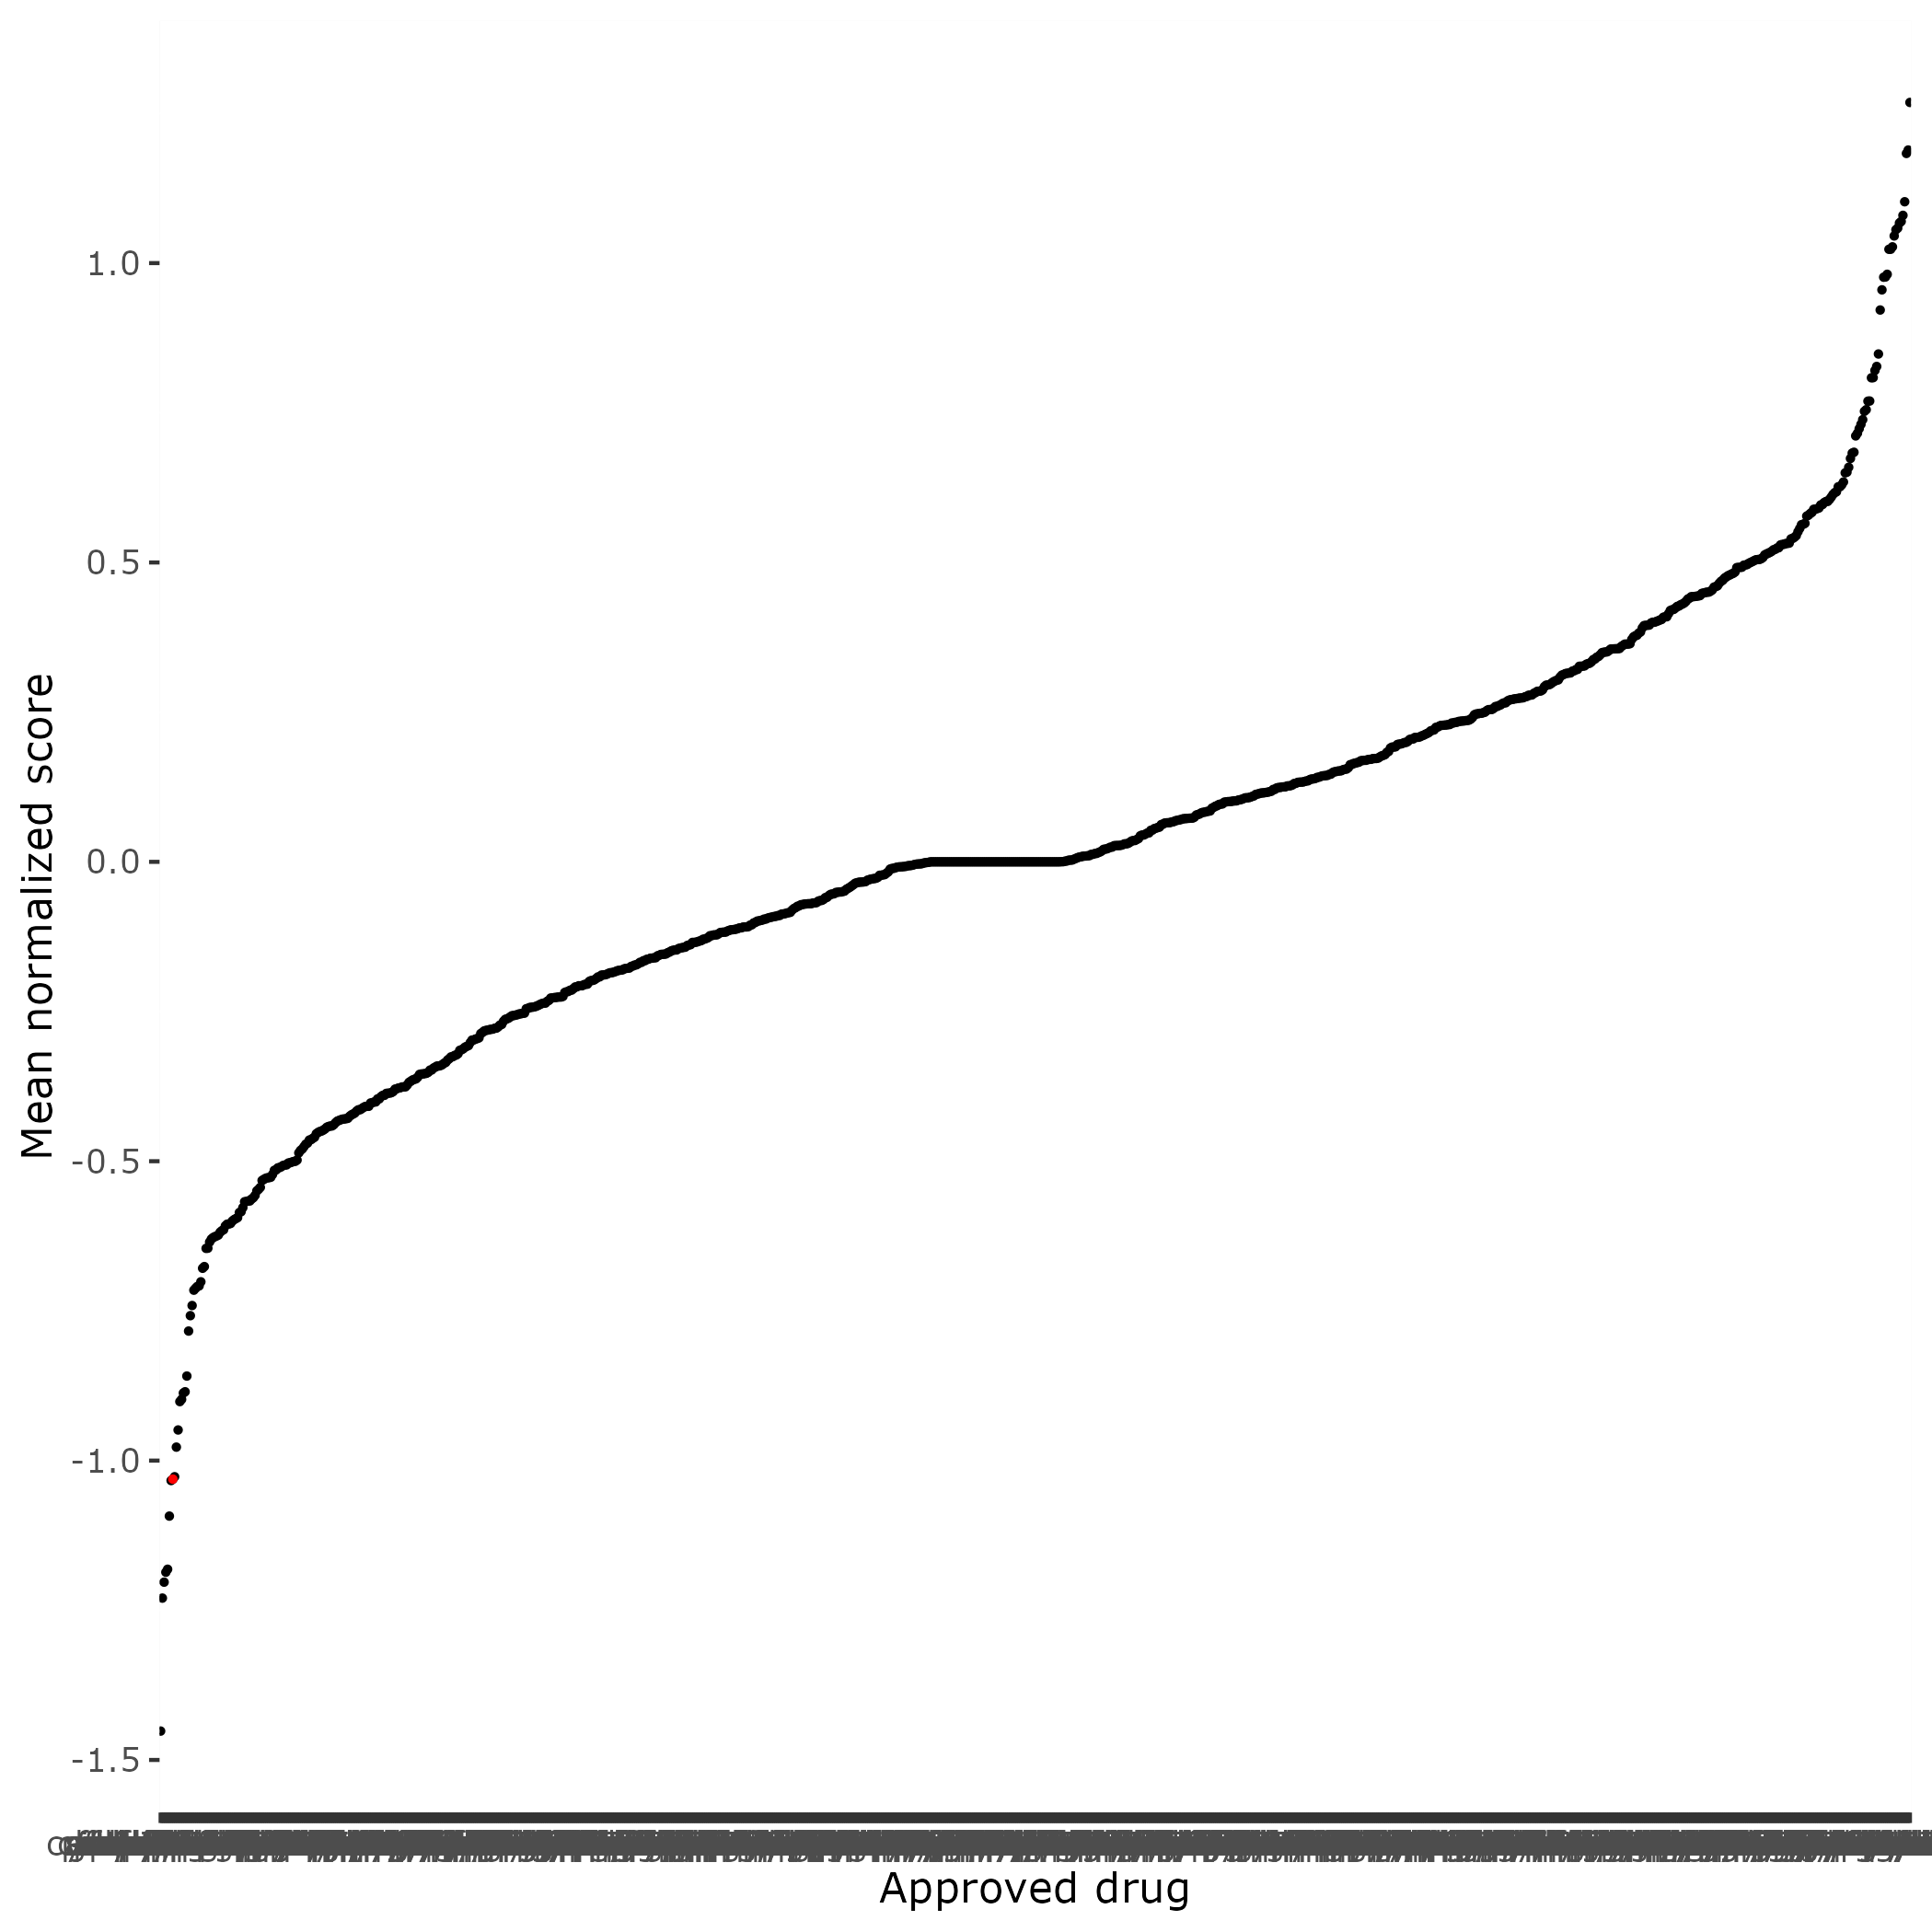

In [1]:
from IPython.display import display
from PIL import Image

plot="/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/All.Drugs2.png"
display(Image.open(plot))



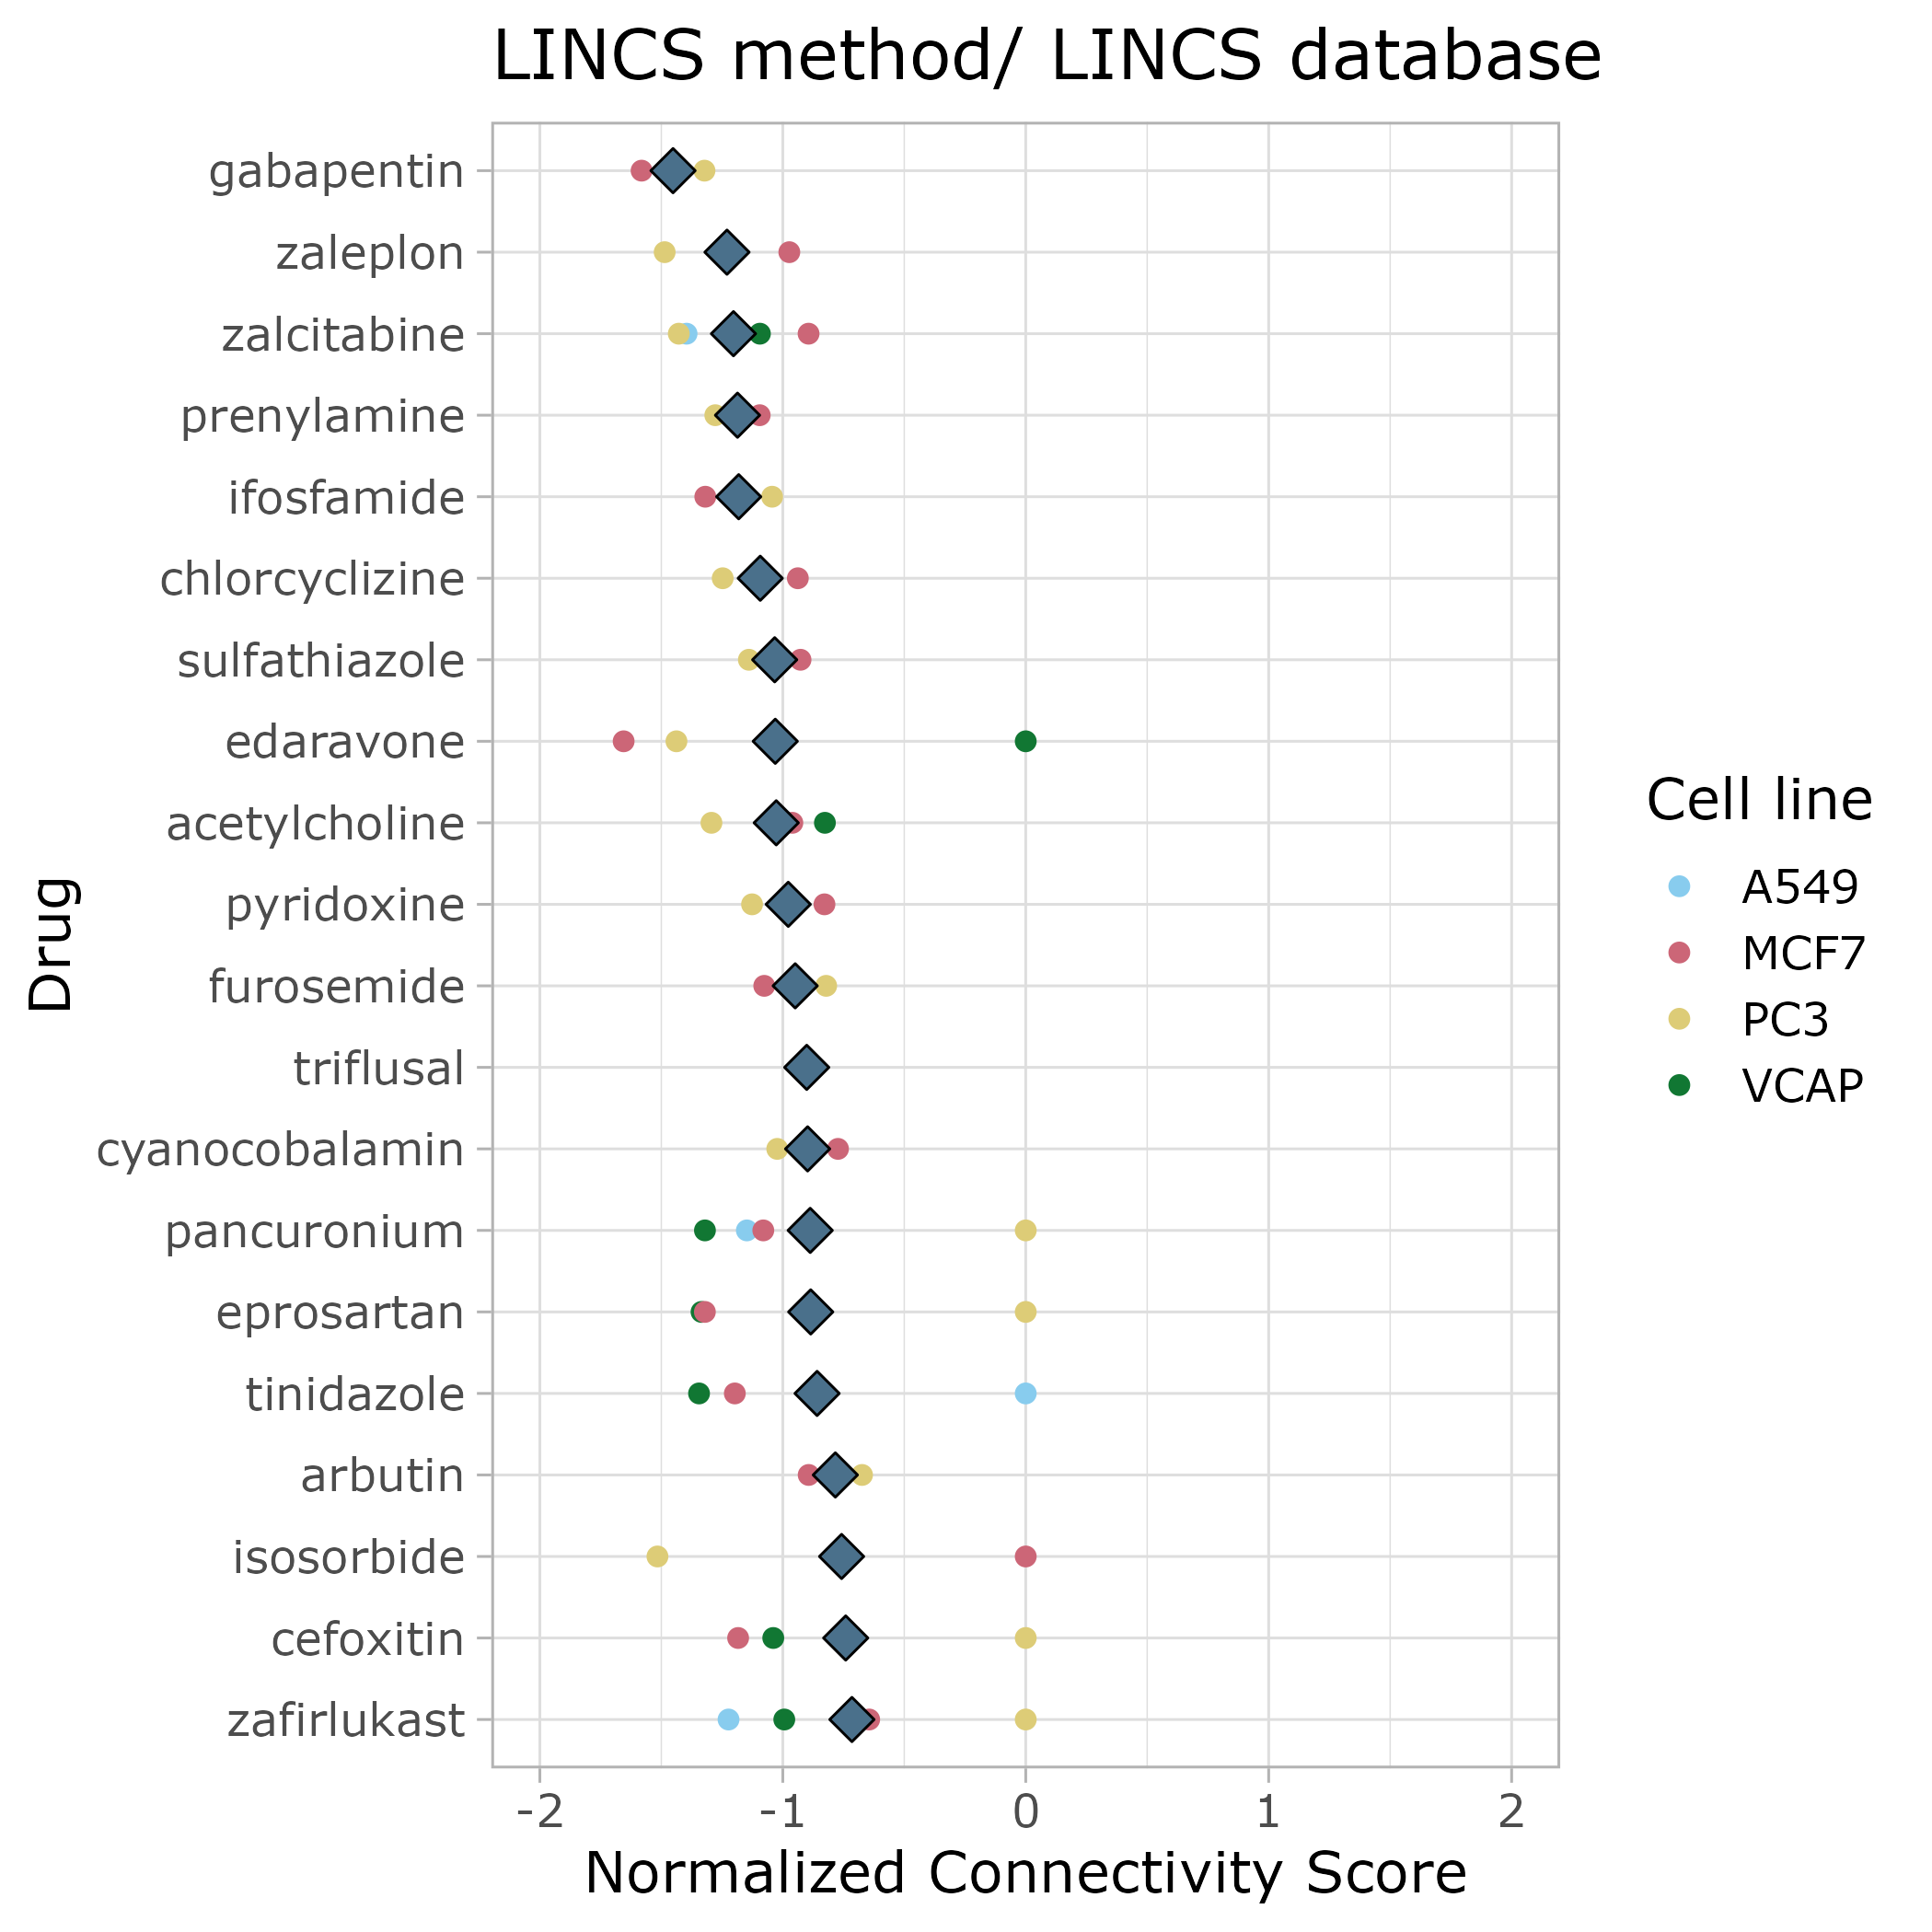

In [22]:

from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/DrugBank.approved.VR.ALS.lincsmethod.lincsDB.SpinalCordc1FDR.png', width = 1000, height = 800)
